In [1]:
import torch, detectron2
# !nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.13 ; cuda:  cu116
detectron2: 0.6


/home/cituser/anaconda3/envs/sp973/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
from detectron2.checkpoint import DetectionCheckpointer, Checkpointer
import detectron2.utils.comm as comm
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation.fast_eval_api import COCOeval_opt
import glob
import cv2
from matplotlib import pyplot as plt
import torch
import time
import datetime
import logging

/home/cituser/anaconda3/envs/sp973/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_path = "../"
register_coco_instances("train", {}, os.path.join(project_path, "data/annotations/A12/vanilla/train.json"), os.path.join(project_path, "data/A12"))
register_coco_instances("val", {}, os.path.join(project_path, "data/annotations/A12/vanilla/val.json"), os.path.join(project_path, "data/A12"))
register_coco_instances("test", {}, os.path.join(project_path, "data/annotations/A12/vanilla/test.json"), os.path.join(project_path, "data/A12"))

In [3]:
cfg = get_cfg()
# Use pretrained model parameters of mask_rcnn_R_50_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
cfg.DATALOADER.NUM_WORKERS = 2 # Dataloader workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # Model weights
cfg.SOLVER.IMS_PER_BATCH = 5 # Images per batch
cfg.SOLVER.BASE_LR = 0.001 # Base learning rate
cfg.SOLVER.MAX_ITER = 10000 # Max iteration
cfg.SOLVER.STEPS = (2000,3000,4000,5000,) # Steps on decaying lr
cfg.SOLVER.NUM_DECAYS = 4 # Total lr decay
cfg.SOLVER.GAMMA = 0.2 # Decay to gamma times previous lr
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 # Save checkpoint every 1000 iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
cfg.MODEL.MASK_ON = True # Mask
cfg.OUTPUT_DIR = os.path.join(project_path, "notebooks/output/")
cfg.TEST.EVAL_PERIOD = 500
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

[05/20 03:35:37 d2.data.datasets.coco]: Loaded 8175 images in COCO format from ../data/annotations/A12/vanilla/train.json
[05/20 03:35:37 d2.data.datasets.coco]: Loaded 2453 images in COCO format from ../data/annotations/A12/vanilla/val.json


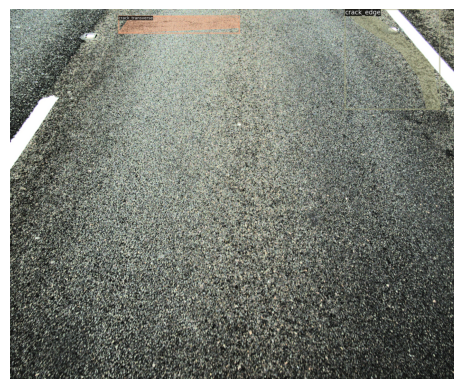

In [24]:
train_ds = DatasetCatalog.get("train")
val_ds = DatasetCatalog.get("val")
metadata = MetadataCatalog.get("train")
for d in train_ds[1486:1487]:
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    out = v.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.show()
    plt.savefig('A12_label_sample2.png', bbox_inches='tight', pad_inches = 0)